In [1]:
!pip install torchmetrics > None
!pip install pytorch-lightning > None

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.utils import resample
from torchmetrics import AUROC

%matplotlib inline

import logging

import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset

In [3]:
from torch.utils.data import DataLoader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
torch.manual_seed(42)
random.seed(42)

In [7]:
df = pd.read_csv("/content/drive/MyDrive/WISDM/WISDM_ar_v1.1_raw.txt", sep = ' ', header = None)

df['lenght'] = df[0].apply(lambda x: x.split(',')).apply(lambda x: len(x))
filtred_df = df[~df['lenght'].isin([7, 11])]
filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))

columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
for i, el in enumerate(columns):
  if i != len(columns)-1:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
  else:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i][:-1])

filtred_df = filtred_df.drop(columns = [0, 'lenght', 'timestamp'])

<ipython-input-7-d5fd2ef54d06>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))
<ipython-input-7-d5fd2ef54d06>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
<ipython-input-7-d5fd2ef54d06>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [8]:
def transform_activity(x):
  if x in ['Jogging', 'Upstairs', 'Downstairs']:
    return 1
  elif x in ['Walking', 'Sitting', 'Standing']:
    return 0


In [9]:
filtred_df.activity = filtred_df.activity.apply(lambda x: transform_activity(x))

In [10]:
filtred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086466 entries, 0 to 1098203
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   user      1086466 non-null  object
 1   activity  1086466 non-null  int64 
 2   x-axis    1086466 non-null  object
 3   y-axis    1086466 non-null  object
 4   z-axis    1086466 non-null  object
dtypes: int64(1), object(4)
memory usage: 49.7+ MB


In [11]:
def transform(x):
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x


In [12]:
for el in filtred_df.columns:
  filtred_df[el] = filtred_df[el].apply(lambda x: transform(x))


In [13]:
for col in ['x-axis', 'y-axis', 'z-axis']:
  mean_value = filtred_df[col].mean()
  sigma = filtred_df[col].std()
  filtred_df[col] = filtred_df[col].apply(lambda x: (x-mean_value)/sigma)

In [14]:
unique_users = list(filtred_df["user"].unique())
random.shuffle(unique_users)

In [15]:
filtred_df['user'].value_counts()

20.0    56632
19.0    45383
31.0    44282
8.0     41188
29.0    38245
14.0    38192
13.0    37092
34.0    35947
32.0    35506
3.0     35161
27.0    34957
10.0    34883
18.0    32810
12.0    32641
26.0    32578
36.0    32261
11.0    31659
7.0     30967
1.0     29978
6.0     29704
33.0    29453
5.0     28509
15.0    28154
24.0    25736
23.0    25673
30.0    25334
21.0    23703
2.0     23525
35.0    22394
22.0    22310
17.0    22020
28.0    21358
16.0    20469
25.0    13468
9.0     12923
4.0     11371
Name: user, dtype: int64

In [16]:
def group_by_user(df, user):
  return df[df['user'] == user].reset_index(drop = True)

def create_window(df, overlay, window_size, train_x, train_y):
  for i in range(0, df.shape[0], overlay):
    df_sub = df.iloc[i:i+window_size]

    if df_sub.shape[0] == window_size:
      train_x.append(df_sub[['x-axis', 'y-axis', 'z-axis']].to_numpy())
      train_y.append(df_sub['activity'].mode().iloc[0])

  return train_x, train_y


train_x = []
train_y = []

window_size = 100
overlay = 50

users = unique_users[12:]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, train_x, train_y)

print (len(train_x), len(train_y))


15078 15078


In [17]:
test_x = []
test_y = []

users = unique_users[12:18]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, test_x, test_y)

print (len(test_x), len(test_y))


3775 3775


In [18]:
control_x = []
control_y = []

users = unique_users[18:22]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, control_x, control_y)

print (len(control_x), len(control_y))

2516 2516


In [19]:
train_dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last = True)

test_dataset = TensorDataset(torch.tensor(test_x, dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last = True)

<ipython-input-19-bab83bad87de>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float32), torch.tensor(train_y, dtype=torch.float32))


In [20]:
control_dataset = TensorDataset(torch.tensor(control_x, dtype=torch.float32), torch.tensor(control_y, dtype=torch.float32))
control_loader = DataLoader(control_dataset, batch_size=128, shuffle=True, drop_last = True)

In [21]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.lstm1 = nn.LSTM(input_size = 3, hidden_size = 1024, bidirectional=True, batch_first=True)
    self.lstm2 = nn.LSTM(input_size = 2048, hidden_size = 768, bidirectional=True, batch_first=True)
    self.lstm3 = nn.LSTM(input_size = 3, hidden_size = 768, bidirectional=True, batch_first=True)
    self.lstm4 = nn.LSTM(input_size = 3072, hidden_size = 512, bidirectional=True, batch_first=True)
    self.lstm5 = nn.LSTM(input_size = 1536, hidden_size = 512, bidirectional=True, batch_first=True)
    self.global_max_pooling = torch.nn.Sequential(
    torch.nn.AdaptiveMaxPool1d(1),
    torch.nn.Flatten(),)
    self.dense_1 = nn.Linear(100, 128)
    self.dropout = nn.Dropout(0.05)
    self.dense_2 = nn.Linear(128, 2)
    self.dense_3 = nn.Softmax()

  def forward(self, inputs):
        x1, _ = self.lstm1(inputs)
        l1, _ = self.lstm2(x1)
        l2, _ = self.lstm3(inputs)
        c1 = torch.cat((l1, l2), dim=2)

        l3, _ = self.lstm4(c1)
        l4, _ = self.lstm5(l2)

        c2 = torch.cat((l3, l4), dim=2)
        l6 = self.global_max_pooling(c2)
        l7 = self.dense_1(l6)
        l8 = self.dropout(l7)

        output = self.dense_2(l8)
        output = self.dense_3(output)

        return output

In [22]:
for inputs, labels in train_loader:
  print (inputs.shape, labels.shape)
  break

torch.Size([128, 100, 3]) torch.Size([128])


In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [24]:
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_true, y_pred_labels)
    return accuracy

In [25]:
device

device(type='cuda', index=0)

In [26]:
import gc
train_losses = []
valid_losses = []
def train():
    running_loss = torch.tensor(0.0, device=device)
    y_true = []
    y_pred_probs = []
    model.train()

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        loss.backward()
        optimizer.step()
        running_loss += loss

        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.cpu().detach().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_loss {train_loss}, train_accuracy {accuracy}')
    return train_losses

def valid():
    running_loss = torch.tensor(0.0, device=device)
    y_true = []
    y_pred_probs = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs.float())
            loss = criterion(preds, labels.squeeze().long())

            if not loss.isnan():
              running_loss += loss

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(preds.detach().cpu().numpy())

        valid_loss = running_loss/(i+1)
        valid_losses.append(valid_loss.cpu().detach().numpy())

        y_true = np.array(y_true)
        y_pred_probs = np.array(y_pred_probs)
        accuracy = calculate_accuracy(y_true, y_pred_probs)

        print(f'validation_loss {valid_loss}, validation_accuracy {accuracy}')
    return valid_losses, accuracy

epochs = 20
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    train_losses = train()
    valid_losses, _ = valid()
    gc.collect()

epochs 1/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.6888217329978943, train_accuracy 0.5468082264957265


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 3.2772254943847656, validation_accuracy 0.5299030172413793
epochs 2/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.6705309748649597, train_accuracy 0.5416666666666666


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 3.283024311065674, validation_accuracy 0.5239762931034483
epochs 3/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.6513432860374451, train_accuracy 0.5755208333333334


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 3.177919864654541, validation_accuracy 0.6179956896551724
epochs 4/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.6389609575271606, train_accuracy 0.7170138888888888


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 3.1237945556640625, validation_accuracy 0.7699353448275862
epochs 5/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.6281662583351135, train_accuracy 0.7519364316239316


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 3.0183982849121094, validation_accuracy 0.7306034482758621
epochs 6/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.6004834175109863, train_accuracy 0.7761752136752137


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 2.748263120651245, validation_accuracy 0.7491918103448276
epochs 7/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.5532834529876709, train_accuracy 0.8458199786324786


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 2.4876046180725098, validation_accuracy 0.8938577586206896
epochs 8/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.5086134076118469, train_accuracy 0.8654513888888888


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 2.261106014251709, validation_accuracy 0.8803879310344828
epochs 9/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4707966446876526, train_accuracy 0.8691239316239316


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 2.209808826446533, validation_accuracy 0.8733836206896551
epochs 10/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4498824179172516, train_accuracy 0.8797409188034188


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 2.0129666328430176, validation_accuracy 0.908135775862069
epochs 11/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4397417902946472, train_accuracy 0.8818108974358975


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.9915556907653809, validation_accuracy 0.9156788793103449
epochs 12/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4343428909778595, train_accuracy 0.8835470085470085


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.9543484449386597, validation_accuracy 0.9164870689655172
epochs 13/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.43028023838996887, train_accuracy 0.8854166666666666


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.9386924505233765, validation_accuracy 0.9156788793103449
epochs 14/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.424299955368042, train_accuracy 0.8904246794871795


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.9071412086486816, validation_accuracy 0.9226831896551724
epochs 15/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4191987216472626, train_accuracy 0.8946314102564102


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.819470763206482, validation_accuracy 0.9391163793103449
epochs 16/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.41522321105003357, train_accuracy 0.8994391025641025


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.850860357284546, validation_accuracy 0.9329202586206896
epochs 17/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.41448673605918884, train_accuracy 0.898704594017094


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.8355982303619385, validation_accuracy 0.9339978448275862
epochs 18/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4116206765174866, train_accuracy 0.9021768162393162


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.851332187652588, validation_accuracy 0.9302262931034483
epochs 19/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4089702069759369, train_accuracy 0.9051148504273504


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.8317580223083496, validation_accuracy 0.935614224137931
epochs 20/20


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


train_loss 0.4050925672054291, train_accuracy 0.9105235042735043


<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


validation_loss 1.8052339553833008, validation_accuracy 0.9412715517241379


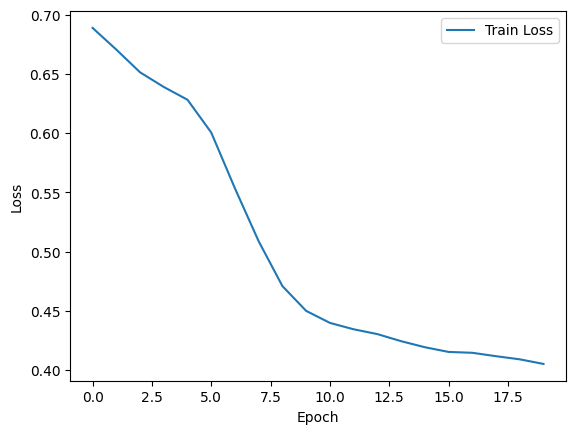

In [27]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

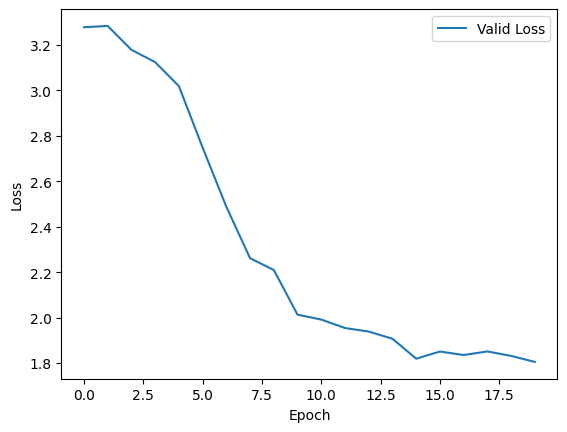

In [28]:
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
def after_argmax(y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    return y_pred_labels

In [32]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(control_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = ['active motion', 'inactive motion']
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f' control_accuracy {accuracy}')

<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


                 precision    recall  f1-score   support

  active motion       0.92      0.97      0.95      1285
inactive motion       0.96      0.91      0.93      1147

       accuracy                           0.94      2432
      macro avg       0.94      0.94      0.94      2432
   weighted avg       0.94      0.94      0.94      2432

 control_accuracy 0.9403782894736842


In [33]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = ['active motion', 'inactive motion']
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'test_accuracy {accuracy}')

<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


                 precision    recall  f1-score   support

  active motion       0.92      0.96      0.94      1777
inactive motion       0.96      0.92      0.94      1935

       accuracy                           0.94      3712
      macro avg       0.94      0.94      0.94      3712
   weighted avg       0.94      0.94      0.94      3712

test_accuracy 0.9407327586206896


In [31]:
y_true = []
y_pred_probs = []
model.eval()

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    class_names = ['active motion', 'inactive motion']
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_accuracy {accuracy}')

<ipython-input-21-a0f25ea1cb77>:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = self.dense_3(output)


                 precision    recall  f1-score   support

  active motion       0.89      0.93      0.91      7256
inactive motion       0.93      0.89      0.91      7720

       accuracy                           0.91     14976
      macro avg       0.91      0.91      0.91     14976
   weighted avg       0.91      0.91      0.91     14976

train_accuracy 0.9069845085470085
